<a href="https://colab.research.google.com/github/AnshulH/NLP-DL-Group2/blob/fnn/NLP_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -r /content/NLP-DL-Group2/
!cd /content && git clone -b fnn https://github.com/AnshulH/NLP-DL-Group2

rm: cannot remove '/content/NLP-DL-Group2/': No such file or directory
Cloning into 'NLP-DL-Group2'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 102 (delta 24), reused 18 (delta 5), pack-reused 46
Receiving objects: 100% (102/102), 30.83 MiB | 5.73 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
import re
from nltk.util import ngrams

In [4]:
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    
    if threshold > -1:
        with open(file_name,'rt', encoding='utf8') as f:
            for line in f:
                line = line.replace('\n','')
                # Added lower-casing
                line = line.lower()
                
                # Strips out all charcters other than alphanumeric
                line = re.sub('[\W_]+', ' ', line, flags=re.UNICODE)
                
                # Strips out numbers
                line = re.sub('\d+', '', line)
                
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt', encoding='utf8') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

In [5]:
params = {
        'd_model': 100,
        'd_hidden': 100,
        'n_layers': 2,
        'batch_size': 20,
        'seq_len': 30,
        'printevery': 5000,
        'window': 3,
        'epochs': 20,
        'lr': 0.0001,
        'dropout': 0.35,
        'clip': 2.0,
        'model': 'FFNN',
        'savename': 'lstm',
        'loadname': None,
        'trainname': '/content/NLP-DL-Group2/hw#1/mix.train.txt',
        'validname': '/content/NLP-DL-Group2/hw#1/mix.valid.txt',
        'testname': '/content/NLP-DL-Group2/hw#1/mix.test.txt'
    }
torch.manual_seed(0)

[vocab,words,train] = read_encode(params['trainname'],[],{},[],3)
print('vocab: %d train: %d' % (len(vocab), len(train)))
[vocab,words,test] = read_encode(params['testname'], vocab,words,[],-1)
print('vocab: %d test: %d' % (len(vocab),len(test)))
params['vocab_size'] = len(vocab)

vocab: 33633 train: 3366260
vocab: 33633 test: 441210


In [6]:
# Returns bios in [(bio without puncutation, label), ...]
# 0: FAKE
# 1: REAL
def read_bios(file_name, labels=False):
    with open(file_name,'rt', encoding='utf8') as f:
        all_bios = f.readlines()
        
    split_bios = []
    curr_bio = ""
    curr_index = 0
    while curr_index < len(all_bios):
        curr_line = all_bios[curr_index].lower()
        # Strips out all charcters other than alphanumeric
        curr_line = re.sub('[\W_]+', ' ', curr_line, flags=re.UNICODE)
        
        # Strips out numbers
        curr_line = re.sub('\d+', '', curr_line)
        
        curr_line = curr_line.strip()
        
        if curr_line == "start bio":
            # Skips their name
            curr_index += 1
        
        elif curr_line == "end bio":
          if labels:
            curr_index += 2
            if "FAKE" in all_bios[curr_index]:
                label = 0
            else:
                label = 1

            split_bios.append((curr_bio, label))
            curr_bio = ""
          
          else:
            split_bios.append((curr_bio, 0))
            curr_bio = ""
        
        else:
            # Check to ensure not empty space
            if curr_line:
                if curr_bio == "":
                    curr_bio = curr_line
                else:
                    curr_bio += " " + curr_line
        
        curr_index += 1
        
    
    return split_bios
    
split_bios = read_bios(params['trainname'], True)


In [10]:
print(split_bios[55])

('aaron john jack sharp july   november   was an american botanist and bryologist considered an expert on mosses the standard author abbreviation sharp is used to indicate this person as the author when citing a botanical name early life sharp was raised on a dairy farm near east liberty ohio he attended ohio wesleyan university and earned his degree in botany in  after receiving his undergraduate degree sharp was introduced to bryology by george elwood nichols while taking his classes at the university of michigan biological station sharp earned his m s from the university of oklahoma while studying under paul sears in career in  sharp moved to knoxville tennessee and began teaching at the university of tennessee although he was accepted into the ph d program at yale university financial troubles led him to complete his doctorate at ohio state university in  sharp became a full professor at the university of tennessee in  and between  and  he was head of the department of botany sharp

In [7]:
# Create windows
# split_bios: [(bio without puncutation, label), ...]
# Returns sliding windows (multiple per biography):
# [
#  [
#   (['Hildebrand', 'Bothe', 'October'], 'September'),
#   (['Bothe', 'October', 'September'], 'was'),
#  ],
#  [
#   ([Hermann', 'Robert', 'Kaiser'], 'September'),
#   ...
#  ]
# ]

# Reference: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
def create_windows(split_bios, window_size):
    sliding_windows = []
    for bio, label in split_bios:
        bio_without_nums = ''.join([i for i in bio if not i.isdigit()])
        tokens = [token for token in bio_without_nums.split(" ") if token != ""]
        
        ngrams = []
        for i in range(len(tokens) - window_size):
            ngrams.append((
                [tokens[i + j] for j in range(window_size)],
                tokens[i + window_size]
            ))
        
        sliding_windows.append((ngrams, label))
    
    return sliding_windows

windows = create_windows(split_bios, 3)

In [8]:
def create_context_and_next_words(windows):
  all_context = []
  all_next_words = []
  skipped_labels = 0

  for (each_bio, bio_label) in windows:
      for context, label in each_bio:
          found_in_words = [word in words for word in context]
          found_in_words.extend([label in words])
          if all(found_in_words):
              all_context.append([words[word][0] for word in context])
              all_next_words.append([words[label][0]])
          else:
              all_context.append([0] * len(context))
              all_next_words.append([0])
              
              skipped_labels += 1

  return torch.LongTensor(all_context), torch.LongTensor(all_next_words)

# Skipping certain sliding windows because they weren't found in the dictionary
# Unk'd?
# print(skipped_labels)

all_context, all_next_words = create_context_and_next_words(windows)

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64

dataset = TensorDataset(all_context, all_next_words)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
class FFNN(nn.Module):
    # d_model = embedding dimensions
    def __init__(self, vocab, words,d_model, d_hidden, dropout):
        super().__init__() 
    
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.dropout = dropout
        self.embeds = nn.Embedding(self.vocab_size,d_model)
        
        # Context size * dimensions for input
        # Hidden layer neurons was more difficult to find information
        self.linear1 = nn.Linear(3 * d_model, 512)
        self.linear2 = nn.Linear(512, self.vocab_size)

    def forward(self, src):
        embeds = self.embeds(src).view((BATCH_SIZE, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    def lookup(self, src):
        embeds = self.embeds(src).flatten(1, 2)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
                
    def init_weights(self):
        pass

In [12]:
# AFTER BATCHING

model = FFNN(vocab, words, d_model=100, d_hidden=100, dropout=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load('/content/gdrive/My Drive/fnn.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

# model = FFNN(vocab, words, d_model=100, d_hidden=100, dropout=0.1)
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0
    for i, (context, label) in enumerate(dataloader):
        log_probabilities = model(context)
        # Collapsing labels to correct dimensions
        label = label.squeeze()
        loss = loss_function(log_probabilities, label)
        
        loss.backward()
        optimizer.step()
        
        model.zero_grad()
        
        running_loss += loss.item()

        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
            torch.save({
                'epoch': epoch,
                'batch': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, "/content/gdrive/My Drive/fnn.pt")
            
            break
        
    print("Epoch {}/{}: Loss {:.4f}".format(epoch, 10, loss))
    
print("Finished!")

  batch 200 loss: 6.585859899520874
Epoch 0/10: Loss 4.5982
  batch 200 loss: 6.00045539855957
Epoch 1/10: Loss 6.2290
  batch 200 loss: 5.794422476291657
Epoch 2/10: Loss 5.6997
  batch 200 loss: 5.75495032787323
Epoch 3/10: Loss 5.8580
  batch 200 loss: 5.663920509815216
Epoch 4/10: Loss 4.9840
  batch 200 loss: 5.680743398666382
Epoch 5/10: Loss 6.1952
  batch 200 loss: 5.610845267772675
Epoch 6/10: Loss 5.6702
  batch 200 loss: 5.638333353996277
Epoch 7/10: Loss 5.3960
  batch 200 loss: 5.506783947944641
Epoch 8/10: Loss 4.9407
  batch 200 loss: 5.596408195495606
Epoch 9/10: Loss 6.0909
Finished!


In [51]:
model = FFNN(vocab, words, d_model=100, d_hidden=100, dropout=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('/content/gdrive/My Drive/fnn.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

FFNN(
  (embeds): Embedding(33633, 100)
  (linear1): Linear(in_features=300, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=33633, bias=True)
)

In [52]:
import torch
from torch.utils.data import DataLoader, TensorDataset

split_bios = read_bios('/content/NLP-DL-Group2/hw#1/mix.valid.txt', True)
windows = create_windows(split_bios, 3)

all_sliding_windows = [item[0] for item in windows]
all_bio_labels = [item[1] for item in windows]

BATCH_SIZE = 64

In [53]:
# Makes context + true words for each given bio
# @param: pass it the sliding windows of a given bio
# sliding window is a list of pairs
# [(['hildebrand', 'bothe', 'october'], 'september'), (['bothe', 'october', 'september'], 'was'), ...]

def make_context_and_true_words_per_bio(bio):
  all_context = []
  all_next_words = []

  for context, label in bio:
      found_in_words = [word in words for word in context]
      found_in_words.extend([label in words])
      if all(found_in_words): 
          all_context.append([words[word][0] for word in context])
          all_next_words.append([words[label][0]])
      else:  
          all_context.append([0] * len(context))
          all_next_words.append([0])

  return torch.LongTensor(all_context), torch.LongTensor(all_next_words)

In [54]:
# probabilites_fake = torch.FloatTensor([])
probabilites_fake = []
# probabilites_true = torch.FloatTensor([])
probabilites_true = []

for i in range(len(all_sliding_windows)):
  all_sliding_windows_for_bio = all_sliding_windows[i]
  context, true_words = make_context_and_true_words_per_bio(all_sliding_windows_for_bio)
  bio_label = all_bio_labels[i] 
  log_probability_table = model.lookup(context)

  curr_probabilities = torch.FloatTensor([])

  for idx_curr_context, curr_context in enumerate(log_probability_table):
    true_word_for_curr_context = true_words[idx_curr_context]
    probability_for_true_word = curr_context[true_word_for_curr_context]
    curr_probabilities = torch.cat([curr_probabilities, probability_for_true_word])

  curr_probabilities = torch.Tensor.mean(curr_probabilities).tolist() 
  if bio_label == 1:
    if len(probabilites_true) < 200:
      # probabilites_true = torch.stack([curr_probabilities, probabilites_true])
      probabilites_true.append(curr_probabilities)
  else:
    if len(probabilites_fake) < 200:
      # probabilites_fake = torch.stack([curr_probabilities, probabilites_fake])
      probabilites_fake.append(curr_probabilities)

  # print(len(probabilites_fake), len(probabilites_true))
  
  if len(probabilites_fake) == 200 and len(probabilites_true) == 200:
    break

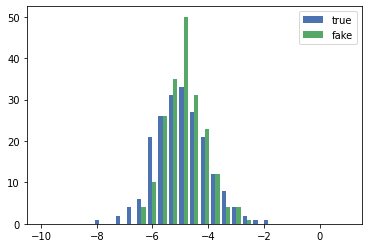

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-deep')

x = probabilites_true
y = probabilites_fake
bins = np.linspace(-10, 1, 30)

plt.hist([x, y], bins, label=['true', 'fake'])
plt.legend(loc='upper right')
plt.show()


In [39]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__() 
        self.layer_1 = nn.Linear(10, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 10) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1) 
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) 
        x = self.relu(self.layer_2(x)) 
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [40]:
# for training
n = len(probabilites_true)
probabilites_true.extend(probabilites_fake)
y_train = [1]*n
n = len(probabilites_fake)
y_train.extend([0]*n)

In [41]:
modelbin = BinaryClassification() 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [42]:
from torch.utils.data import Dataset, DataLoader
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [47]:
train_data = TrainData(torch.FloatTensor(probabilites_true), 
                       torch.FloatTensor(y_train))

In [48]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

In [50]:
EPOCHS = 50
modelbin.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader: 
        optimizer.zero_grad() 
        y_pred = modelbin(X_batch)  
        loss = criterion(y_pred.unsqueeze(1), y_batch.unsqueeze(1)) 
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() 
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

Epoch 001: | Loss: 0.73676
Epoch 002: | Loss: 0.75122
Epoch 003: | Loss: 0.77162
Epoch 004: | Loss: 0.74016
Epoch 005: | Loss: 0.76976
Epoch 006: | Loss: 0.75717
Epoch 007: | Loss: 0.74434
Epoch 008: | Loss: 0.75702
Epoch 009: | Loss: 0.73884
Epoch 010: | Loss: 0.79625
Epoch 011: | Loss: 0.76811
Epoch 012: | Loss: 0.76860
Epoch 013: | Loss: 0.76638
Epoch 014: | Loss: 0.75435
Epoch 015: | Loss: 0.74507
Epoch 016: | Loss: 0.70791
Epoch 017: | Loss: 0.74229
Epoch 018: | Loss: 0.77835
Epoch 019: | Loss: 0.75325
Epoch 020: | Loss: 0.76502
Epoch 021: | Loss: 0.76900
Epoch 022: | Loss: 0.73876
Epoch 023: | Loss: 0.72430
Epoch 024: | Loss: 0.76905
Epoch 025: | Loss: 0.73951
Epoch 026: | Loss: 0.76804
Epoch 027: | Loss: 0.76479
Epoch 028: | Loss: 0.74584
Epoch 029: | Loss: 0.77239
Epoch 030: | Loss: 0.78826
Epoch 031: | Loss: 0.76674
Epoch 032: | Loss: 0.74111
Epoch 033: | Loss: 0.78468
Epoch 034: | Loss: 0.76479
Epoch 035: | Loss: 0.73855
Epoch 036: | Loss: 0.73234
Epoch 037: | Loss: 0.74053
E

In [56]:
# for testing
n = len(probabilites_true)
probabilites_true.extend(probabilites_fake)
y_test = [1]*n
n = len(probabilites_fake)
y_test.extend([0]*n)

In [57]:
class TestData():
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
     
test_data = TestData(torch.FloatTensor(probabilites_true))

In [58]:
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=True)

In [59]:
y_pred_list = []
modelbin.eval()
with torch.no_grad():
    for X_batch in test_loader: 
        y_test_pred = modelbin(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [60]:
y_pred = []
for i in y_pred_list:
  for j in i:
    y_pred.append(j) 

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[119,  81],
       [115,  85]])